In [112]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

### Create dataset

In [113]:
def get_dataset(nb_datas, pct_unlabelled, type):
    
    if type == 'gaussian':
        x = np.zeros((nb_datas, 2))
        y = np.zeros(nb_datas)

        sigma1 = [[1, 0], [0, 1]]
        mu1 = [0, 0]
        x[:nb_datas // 2,:] = np.random.multivariate_normal(mu1, sigma1, nb_datas // 2)
        y[:nb_datas // 2] = 0
        
        sigma2 = [[1, 0], [0, 1]]
        mu2 = [1, 1]
        x[nb_datas // 2:,:] = np.random.multivariate_normal(mu2, sigma2, nb_datas // 2)
        y[nb_datas // 2:] = 1
        
    elif type == 'moon':
        x, y = make_moons(n_samples=nb_datas, shuffle=True, noise=0.1, random_state=None)

    y_true = np.copy(y)
    unlabeled_idx = np.random.choice(np.arange(0,nb_datas), int(nb_datas*pct_unlabelled), replace=False)
    y[unlabeled_idx] = -1
    
    return x, y, y_true

def label_to_color(y):
    if y == -1:
        color = [0.4, 0.4, 0.4]
    elif y == 0:
        color = [1, 0, 0]
    elif y == 1:
        color = [0, 1, 0]
    return color

### Set parameters

In [114]:
nb_datas = 100
nb_classes = 2
k = 7
sigma = 0.1
kernel = 'rbf'
nb_iter = 100

In [ ]:
x, y, y_true = get_dataset(nb_datas = 100, pct_unlabelled=0.95, type='moon')

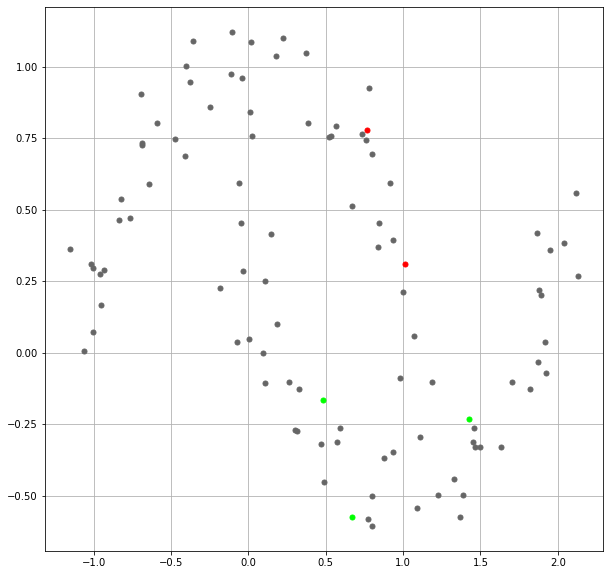

In [115]:
plt.figure(figsize = (10, 10))
for i in range(len(y)):
    plt.plot(x[i,0], x[i,1], '.', c=label_to_color(y[i]), markersize=10)
plt.grid()
plt.show()

### Kernel

$$ K(x,x') = \exp(-\frac{\lVert x - x'\rVert^2}{\sigma^2}) $$

In [116]:
def get_rbf(d, sigma):
    return np.exp(- d**2 / sigma**2)

def get_knn(distance_matrix, k):
    k_nn_graph = np.zeros(distance_matrix.shape, dtype=bool)
    for i in range(len(k_nn_graph)):
        k_nearest_neighbors = np.argsort(distance_matrix[i])[:k+1]
        k_nn_graph[i][k_nearest_neighbors] = True
        k_nn_graph[i][i] = False
    return k_nn_graph

### Distance Matrix

In [117]:
def get_distance_matrix(x):
    distance_matrix = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            distance_matrix[i,j] = np.linalg.norm(x[i] - x[j])
    return distance_matrix

In [118]:
distance_matrix = get_distance_matrix(x)

if kernel == 'knn':
    graph = get_knn(distance_matrix, k=10)
elif kernel == 'rbf':
    graph = get_rbf(distance_matrix, sigma)

### Set transition Matrix

In [119]:
T = np.zeros(graph.shape)
for i in range(len(graph)):
    T[i] = graph[i] / sum(graph[i])

### Set labels distribution

In [120]:
Y = np.zeros((nb_datas, 2))
unlabelled = y == -1
for i ,label in enumerate(y):
    if label != -1:
        Y[i, int(label)] = 1
    else:
        Y[i] = np.ones(2) / 2

### Propagate labels

In [121]:
for _ in range(nb_iter):
    Y =  T @ Y
    for i ,label in enumerate(y):
        if label != -1:
            c = np.zeros(2)
            c[int(label)] = 1.0
            Y[i] = c
        else:
            Y[i] / Y[i].sum()
y_pred = np.argmax(Y, axis=1)

### Get propagated labels

In [122]:
acc = sum(y_pred[unlabelled] == y_true[unlabelled]) / sum(unlabelled)
print(f'Accuracy : {acc}')

Accuracy : 0.9789473684210527


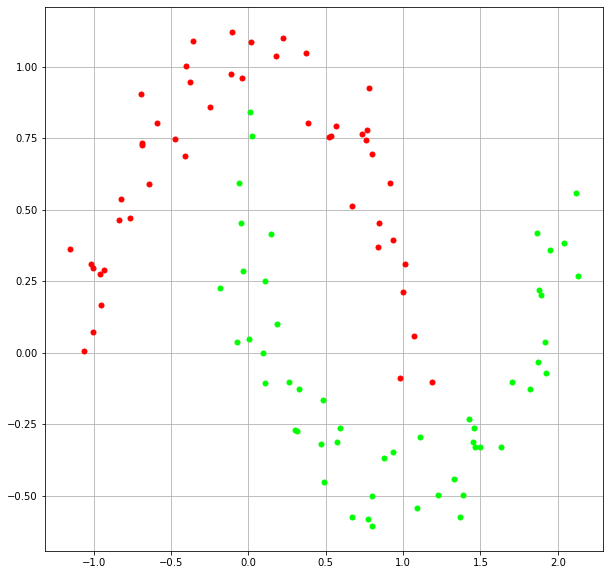

In [123]:
plt.figure(figsize = (10, 10))
for i in range(len(y)):
    plt.plot(x[i,0], x[i,1], '.', c=label_to_color(y_pred[i]), markersize=10)
plt.grid()
plt.show()

In [124]:
acc = sum(y_true[unlabelled] == np.argmax(Y, axis=1)[unlabelled]) / sum(unlabelled)
print(f'Accuracy : {acc}')

Accuracy : 0.9789473684210527


### Compare with RandomForestClassifier

In [125]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x[~unlabelled], y[~unlabelled])
y_pred = clf.predict(x)

In [126]:
acc = sum(y_pred[unlabelled] == y_true[unlabelled]) / sum(unlabelled)
print(f'Accuracy : {acc}')

Accuracy : 0.5263157894736842


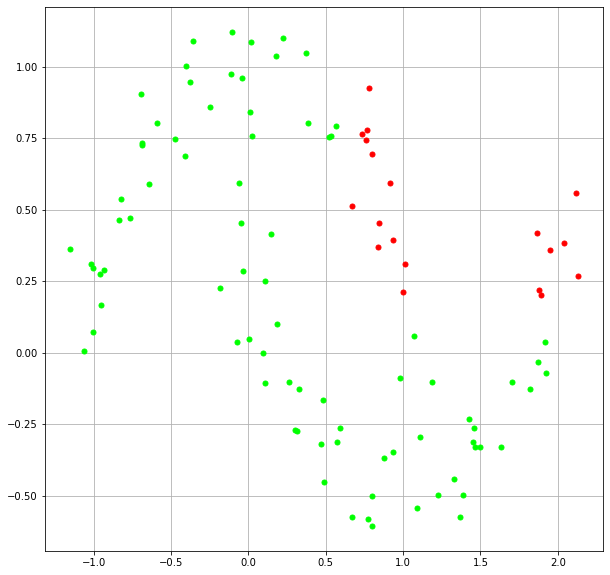

In [127]:
plt.figure(figsize = (10, 10))
for i in range(len(y)):
    plt.plot(x[i,0], x[i,1], '.', c=label_to_color(y_pred[i]), markersize=10)
plt.grid()
plt.show()